In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



from training.train import train_model, train_protonet
from utils.transforms import get_transforms, get_imagenet_transforms, get_tiny_imagenet_transforms
from utils.evaluation import evaluate_model
from models.ResNet_SC import ModifiedResNet18#, ModifiedResNet50
from models.ResNet import ResNet18, ResNet50
from models.ProtoNet import ProtoNet18
from models.FILM import FiLMNet18_SGC, FiLMNet50_SGC
from dataset.Image_Classification import ImgClassificationDataset, ImgClassificationDatasetHF, CIFAR10C, FewShotDataset, ImageNetC, load_cifar10

from models.TopoConv import TopoResNet18
from models.SimpConv import ExpandedSimplicialResNet

/Users/codiri/installs/miniconda3/envs/SCNN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Hyperparameters
batch_size = 32
num_epochs = 100
lr = 0.0005
num_classes = 1000

#loss_fn = "ce"
use_koleo_loss = True

CIFAR10C_ROOT = "./data/cifar/CIFAR-10-C"

# List of all 15 corruption names in CIFAR-10-C (standard ordering)
corruptions = [
	"gaussian_noise", "shot_noise", "impulse_noise",
	"defocus_blur", "glass_blur", "motion_blur", "zoom_blur",
	"snow", "frost", "fog", "brightness",
	"contrast", "elastic_transform", "pixelate",
	"jpeg_compression"
]

# Select device: prefer CUDA, then Apple MPS (for Apple Silicon), otherwise CPU
if torch.cuda.is_available():
	device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
	device = torch.device("mps")
else:
	device = torch.device("cpu")

print(f"Using device: {device}")



Using device: mps


## 1) Load the data

In [3]:
train_transform = get_transforms(split='train')
test_transform = get_transforms(split='test')

imagenet_train_transform = get_imagenet_transforms(split='train')
imagenet_test_transform = get_imagenet_transforms(split='test')

t_imagenet_train_transform = get_tiny_imagenet_transforms(split='train')
t_imagenet_test_transform = get_tiny_imagenet_transforms(split='test')

train_dataset = datasets.CIFAR10(
	root="./data",          
	train=True,             
	download=True,          
	transform=train_transform
)

test_dataset = datasets.CIFAR10(
	root="./data",
	train=False,
	download=True,
	transform=test_transform
)

train_loader = DataLoader(
	train_dataset,
	batch_size=batch_size,
	shuffle=True,    
	num_workers=2     
)

test_loader = DataLoader(
	test_dataset,
	batch_size=batch_size,
	shuffle=False,  
	num_workers=2
)

# load ImageNet
"""
imagenet_train_dataset = datasets.ImageFolder(
	root="./data/imagenet/imagenet/train",
	transform=imagenet_train_transform,
)

imagenet_test_dataset = datasets.ImageFolder(
	root="./data/imagenet/imagenet/train",
	transform=imagenet_test_transform
)

imagenet_train_loader = DataLoader(
	imagenet_train_dataset,
	batch_size=128,
	shuffle=True,         
)

imagenet_test_loader = DataLoader(
	imagenet_test_dataset,
	batch_size=128,
	shuffle=False,     
)
"""

# load tiny-imagenet
t_imagenet_data = load_dataset("clane9/imagenet-100")

train_t_imagenet_data = t_imagenet_data["train"]
val_t_imagenet_data = t_imagenet_data["validation"]
print(train_t_imagenet_data['image'])

"""
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
	img = train_t_imagenet_data[i]['image']
	axs[i].imshow(img)
	axs[i].axis('off')
	axs[i].set_title(f"Label: {train_t_imagenet_data[i]['label']}")
plt.show()
"""

train_t_imagenet_ds = ImgClassificationDataset(
	data = train_t_imagenet_data["image"],
	labels = train_t_imagenet_data["label"],
	transform = imagenet_train_transform
)

val_t_imagenet_ds = ImgClassificationDataset(
	data = val_t_imagenet_data["image"],
	labels = val_t_imagenet_data["label"],
	transform = imagenet_test_transform
)

train_t_imagenet_loader = DataLoader(
	train_t_imagenet_ds,
	batch_size=32,
	shuffle=True,
	num_workers=2
)
val_t_imagenet_loader = DataLoader(
	val_t_imagenet_ds,
	batch_size=32,
	shuffle=False,
	num_workers=2
)

# Load Tiny-ImageNet-C
"""
t_imagenet_dataset_c = ImageNetC(
	root_dir="./data/imagenet/Tiny-ImageNet-C",)

t_imagenet_loader_c = DataLoader(
	t_imagenet_dataset_c,
	batch_size=32,
	shuffle=True,
	num_workers=2
)
"""

# cifar10 loader for few-shot learning
cifar10_train_imgs, cifar10_train_labels = load_cifar10(data_dir="./data/cifar-10-batches-py", train=True, img_size=32)
cifar10_test_imgs, cifar10_test_labels = load_cifar10(data_dir="./data/cifar-10-batches-py", train=False, img_size=32)

protonet_train_dataset = FewShotDataset(data=train_t_imagenet_data["image"], labels=train_t_imagenet_data["label"], n_classes=5, n_supp=5, n_queries=10, transform=train_transform)
protonet_test_dataset = FewShotDataset(data=val_t_imagenet_data["image"], labels=val_t_imagenet_data["label"], n_classes=5, n_supp=5, n_queries=10, transform=train_transform)

protonet_train_loader = DataLoader(protonet_train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
protonet_test_loader = DataLoader(protonet_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Column([<PIL.PngImagePlugin.PngImageFile image mode=RGB size=213x160 at 0x1732176E0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x243 at 0x174E4A390>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x213 at 0x175202AB0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x213 at 0x1752028D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=213x160 at 0x175202A80>])


## 2) Create the model

In [4]:
# (1) Plain ResNet-50 (no self-correction)
 
model_plain = ModifiedResNet18(
	num_classes=num_classes,
	use_adabn=False,
	use_cbam=False,
	use_proto=False,
	use_rbn=False,
).to(device)


# (2) ResNet-50 + AdaBN
model_adabn = ModifiedResNet18(
	num_classes=num_classes,
	use_adabn=True,
	use_cbam=False,
	use_proto=False,
	use_rbn=False,
).to(device)

# (3) ResNet-50 + CBAM
model_cbam = ModifiedResNet18(
	num_classes=num_classes,
	use_adabn=False,
	use_cbam=True,
	use_proto=False,
	use_rbn=False,
).to(device)

# (4) ResNet-50 + Prototype Alignment
model_proto = ModifiedResNet18(
	num_classes=num_classes,
	use_adabn=False,
	use_cbam=False,
	use_proto=True,
	use_rbn=False,
).to(device)

print(f"Plain ResNet-18: {model_plain}")
print(f"ResNet-18 with AdaBN: {model_adabn}")
print(f"ResNet-18 with CBAM: {model_cbam}")
print(f"ResNet-18 with Prototype Alignment: {model_proto}")
"""
model_resnet18 = ResNet18(num_classes=10).to(device)
model_resnet50 = ResNet50(num_classes=10).to(device)
model_filmnet18_sgc = FiLMNet18_SGC(c_dim=512, num_classes=num_classes).to(device)
model_filmnet50_sgc = FiLMNet50_SGC(c_dim=512, num_classes=1000).to(device)
model_protonet18 = ProtoNet18(ResNet18, embedding_dim=512, num_classes=num_classes).to(device)
model_protonet50 = ProtoNet18(ResNet50, embedding_dim=2048, num_classes=num_classes).to(device)
print(model_resnet18)
"""

# geometric models, kind of

model_topo_conv = TopoResNet18(num_classes=num_classes).to(device)
model_simp_conv = ExpandedSimplicialResNet(num_classes=num_classes).to(device)


/Users/codiri/installs/miniconda3/envs/SCNN/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/codiri/installs/miniconda3/envs/SCNN/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


model:  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [5]:
models_list={
	'Plain': model_plain,
	'AdaBN': model_adabn,
	'CBAM': model_cbam,
	'Proto': model_proto,
	#'TopoConv': model_topo_conv,
	#'SimpConv': model_simp_conv
}

## 2.1) Load the model


In [6]:
save_dir = os.getcwd()  # Current working directory


for name, model in models_list.items():
	path = os.path.join(save_dir, f"checkpoints/ckpt_epoch_120_{name}.pt")
	print(f"Loading model: from {path}")
	if os.path.exists(path):
		state_dict = torch.load(path, map_location=device)
		model.load_state_dict(state_dict["model_state_dict"])

		print(f"Loaded {name} model from {path}")

	else:
		print(f"File not found: {path}")


Loading model: from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/checkpoints/ckpt_epoch_120_Plain.pt
Loaded Plain model from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/checkpoints/ckpt_epoch_120_Plain.pt
Loading model: from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/checkpoints/ckpt_epoch_120_AdaBN.pt
Loaded AdaBN model from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/checkpoints/ckpt_epoch_120_AdaBN.pt
Loading model: from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/checkpoints/ckpt_epoch_120_CBAM.pt
Loaded CBAM model from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/checkpoints/ckpt_epoch_120_CBAM.pt
Loading model: from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/checkpoints/ckpt_epoch_120_Proto.pt
Loaded Proto model from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/checkpoints/ckpt_epoch_120_Proto.pt


## 3) Register hooks

In [7]:
features = {'Plain': [], 'CBAM': [], 'Proto': [], 'AdaBN': []}

def make_hook(model_name):
	"""
	Create a hook function to extract features from the model.
	"""
	def hook_fn(m, inp, outp):
		# outp shape: [B, C, H, W] → global‐pool → [B, C]
		vec = outp.mean(dim=[2,3]).detach().cpu()
		features[model_name].append(vec)

	return hook_fn

# Register hooks for each model after every residual block
def register_hooks(models, model_names):
	"""
	Register forward hooks for each model to extract features at each residual block.
	"""
	#layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
	layer_ids = [4, 5, 6, 7]  # Adjusted for ResNet18
	for model, name in zip(models, model_names):
		for lid in layer_ids:
			layer = model.backbone[lid]
			#if isinstance(layer, nn.Sequential):
			#	for block in layer:
			#		block.register_forward_hook(make_hook(name))
			#else:
			layer.register_forward_hook(make_hook(name))

register_hooks(models_list.values(), models_list.keys())

40


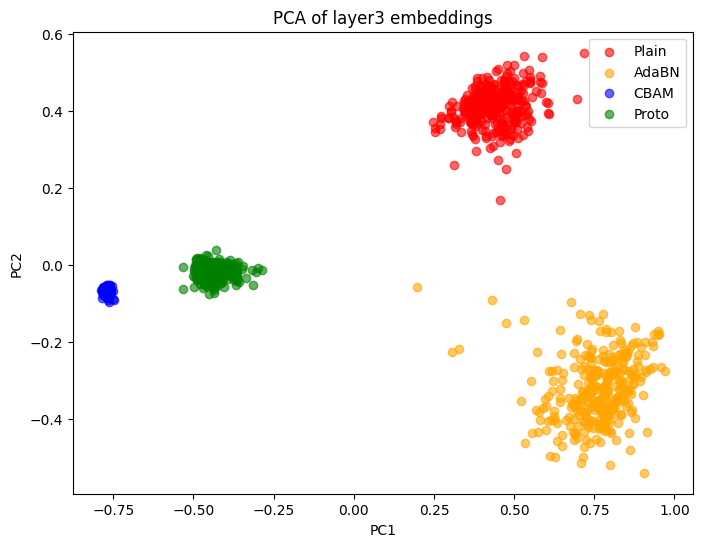

In [ ]:
# Run a few batches
with torch.no_grad():
	for i, (imgs, _) in enumerate(val_t_imagenet_loader):
		if i >= 10: break
		imgs = imgs.to(device)
		for model in models_list.values():
			_ = model(imgs)

# Stack embeddings
print(len(features['Plain']))  # Check shape of one embedding
emb_list, label_list = [], []
for k in models_list.keys():
	# layer 2 features, every 4th element in the list
	embs = torch.cat(features[k][0::4], dim=0).numpy()
	emb_list.append(embs)
	label_list.extend([k]*embs.shape[0])
embs_all = np.vstack(emb_list)
labels  = np.array(label_list)

# PCA to 2D
pca = PCA(n_components=2)
proj = pca.fit_transform(embs_all)

# Scatter‐plot
plt.figure(figsize=(8,6))
colors = {'Plain':'red','CBAM':'blue','Proto':'green', 'AdaBN':'orange'}
for model_type in models_list.keys():
	idx = labels == model_type
	plt.scatter(proj[idx,0], proj[idx,1], 
				c=colors[model_type], label=model_type, alpha=0.6)
plt.legend()
plt.title('PCA of layer3 embeddings')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()